In [1]:
import tensorflow as tf
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [2]:

from __future__ import print_function
from scipy.misc import imsave
import numpy as np
import time
from keras.applications import vgg19
from keras import backend as K

from keras.preprocessing import image
from keras.models import Model
from keras.applications.vgg19 import preprocess_input

import matplotlib.pyplot as plt

%matplotlib inline

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
K.set_session(sess)

Using TensorFlow backend.


In [3]:
content = image.load_img("chien.jpg")
content_array = image.img_to_array(content)


height = content_array.shape[0]
width = content_array.shape[1]


style = image.load_img("style.jpg", target_size=(height,width))
style_array = image.img_to_array(style)

content_array = np.expand_dims(content_array, axis=0)
content_array = preprocess_input(content_array)

style_array = np.expand_dims(style_array, axis=0)
style_array = preprocess_input(style_array)


assert content_array.shape == style_array.shape

generated = K.placeholder(shape=(1,height, width, 3))
content = K.variable(content_array)
style = K.variable(style_array)

In [4]:
model = vgg19.VGG19(weights='imagenet', input_tensor=K.concatenate([content,style,generated], axis=0),include_top=False)

In [5]:
def gram(tensor):
    arranged = K.permute_dimensions(tensor, (2,0,1))
    arranged = K.batch_flatten(arranged)
    return K.dot(arranged, K.transpose(arranged))

In [6]:
def style_loss(gram_style,gram_generated,shape):
    
    return K.sum(K.square(gram_generated - gram_style))/(4.* (3**2)* ((width*height)**2))

In [7]:
def content_loss(content,generated):
    return K.sum(K.square(generated - content))/2.

In [8]:
layers_name = [layer.name for layer in model.layers]
layers_style = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
layers_content = ["block4_conv1"]

In [9]:
model_dict = dict((name,model.get_layer(name).output) for name in layers_name)


In [10]:
loss = K.variable(0)
alpha = 0.001 #content
beta = 1 #style

for name in layers_style:
    layer = model_dict[name]
    layer_generated = layer[2,:,:,:]
    layer_style = layer[1,:,:,:]
    
    gram_style = gram(layer_style)
    gram_generated = gram(layer_generated)
    
    shape = K.shape(gram_style)
    #print(shape)
    loss +=  beta * (style_loss(gram_style, gram_generated,shape)/len(layers_style))

In [11]:
loss_content_variable = K.variable(0.)
for name in layers_content:
    layer = model_dict[name]
    layer_generated = layer[2,:,:,:]
    layer_content = layer[0,:,:,:]
    
    loss += alpha * content_loss(layer_content, layer_generated)
    

In [12]:
grads = K.gradients(loss, generated)[0]

#grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)


In [13]:
iterate = K.function([generated], [loss, grads])

In [14]:
def build_img(img_data, height, width):
    img = img_data.reshape((height, width, 3))

    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    
    
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [15]:
img_data = np.random.uniform(110,150,((1, height, width,3)))

img_data = preprocess_input(img_data)


In [16]:

'''
num_epoch = 100
rate = 0.001
losses = []

for it in range(num_epoch):
    #print("Epoch : " , it)
    loss_value, grads_value = iterate([img_data])
    losses.append(loss_value)
    
    #print("Loss value : ", loss_value)

    #print("Img data :" , img_data[0][0:3][0][0])
    #print("Grad :", grads_value[0][0:3][0][0])
    #print("Rate ", rate)
    update = rate * grads_value
    
    #print("Grad * rate", update[0][0:3][0][0])
    img_data -= update
    #print("New value img", img_data[0:3][0][0][0])

    #print(img_data.shape)
    #print(grads_value.shape)
    
    if it % 10 == 0:
        img_toshow = build_img(np.copy(img_data),height=height,width=width)
        plt.figure()
        plt.imshow(img_toshow)
        plt.show()
'''


'\nnum_epoch = 100\nrate = 0.001\nlosses = []\n\nfor it in range(num_epoch):\n    #print("Epoch : " , it)\n    loss_value, grads_value = iterate([img_data])\n    losses.append(loss_value)\n    \n    #print("Loss value : ", loss_value)\n\n    #print("Img data :" , img_data[0][0:3][0][0])\n    #print("Grad :", grads_value[0][0:3][0][0])\n    #print("Rate ", rate)\n    update = rate * grads_value\n    \n    #print("Grad * rate", update[0][0:3][0][0])\n    img_data -= update\n    #print("New value img", img_data[0:3][0][0][0])\n\n    #print(img_data.shape)\n    #print(grads_value.shape)\n    \n    if it % 10 == 0:\n        img_toshow = build_img(np.copy(img_data),height=height,width=width)\n        plt.figure()\n        plt.imshow(img_toshow)\n        plt.show()\n'

In [17]:
def eval_loss_and_grads(x):   
    x = x.reshape((1, height, width, 3))
    loss_value, grad_values = iterate([x])
    #print("iterated to compute loss and grads")
    return loss_value, grad_values.flatten().astype('float64')

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        #print("compute loss")
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        #print("compute grads")
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values



it :  0
Final picture : 


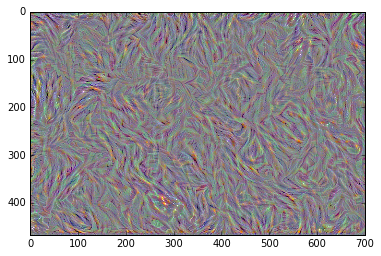

it :  1
Final picture : 


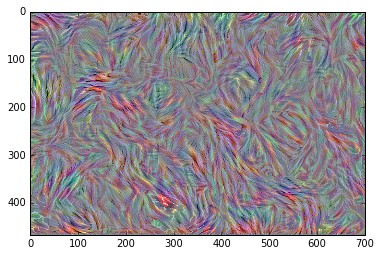

it :  2
Final picture : 


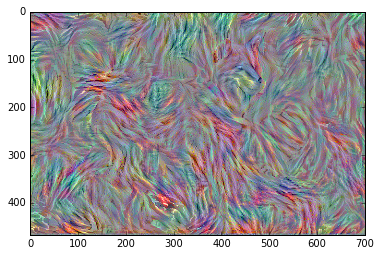

it :  3
Final picture : 


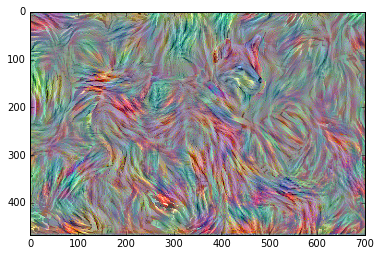

it :  4
Final picture : 


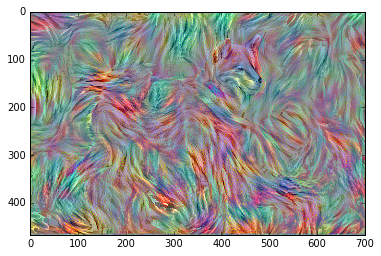

it :  5
Final picture : 


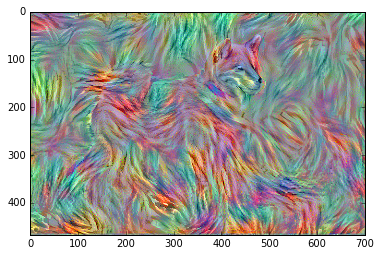

it :  6
Final picture : 


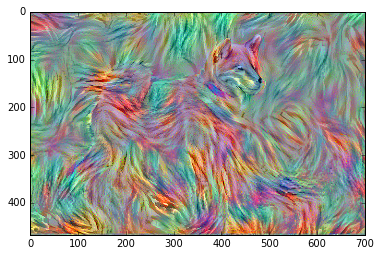

it :  7
Final picture : 


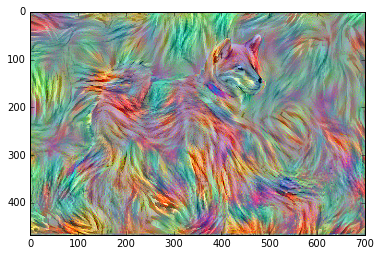

it :  8
Final picture : 


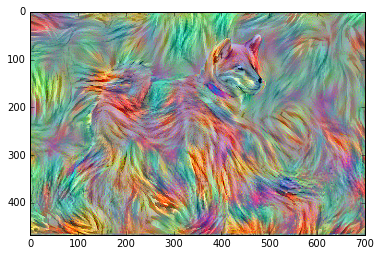

it :  9
Final picture : 


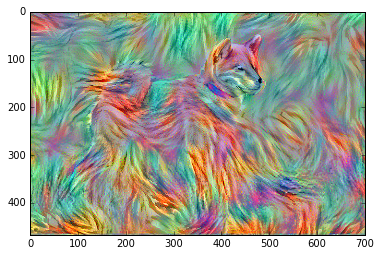

it :  10
Final picture : 


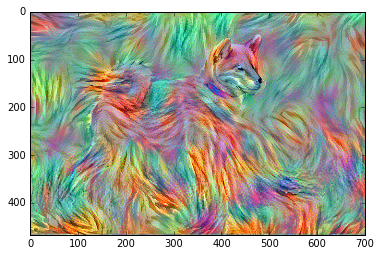

it :  11
Final picture : 


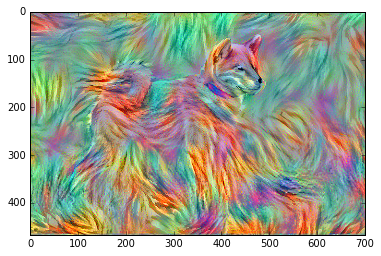

it :  12
Final picture : 


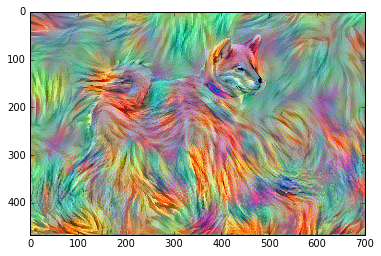

it :  13
Final picture : 


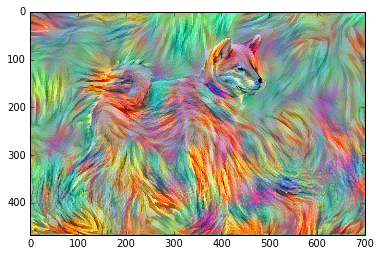

it :  14
Final picture : 


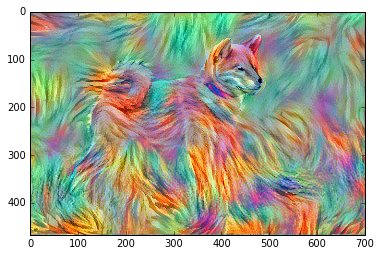

it :  15
Final picture : 


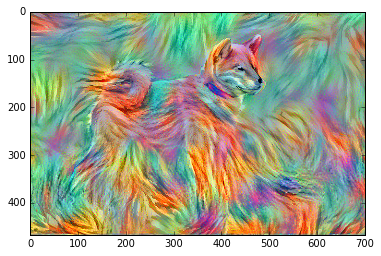

it :  16
Final picture : 


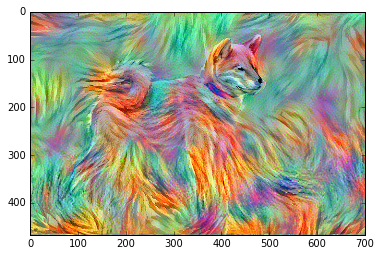

it :  17
Final picture : 


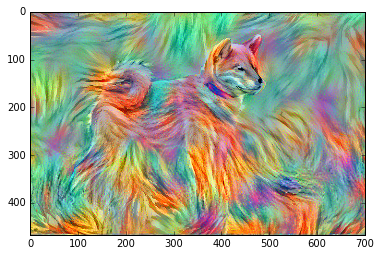

it :  18
Final picture : 


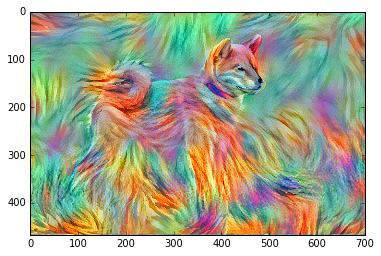

it :  19
Final picture : 


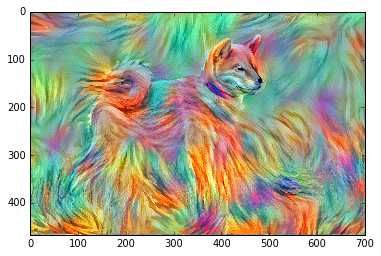

In [18]:
from scipy.optimize import fmin_l_bfgs_b

evaluator = Evaluator()

def display(xk):
    print("Current best image :")
    copy = xk.copy()
    copy = copy.reshape((1, height, width, 3))
    img_toshow = build_img(copy,height=height,width=width)
    plt.figure()
    plt.imshow(copy)
    plt.show()

for it in range(20):
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, img_data.flatten(),fprime=evaluator.grads, maxfun=30)
    
    print("it : ", it)
    print("Final picture : ")
    img_data = x.reshape((1, height, width, 3))
    best_img = img_data.copy()
    best_img = best_img.reshape((1, height, width, 3))
    img_toshow = build_img(best_img,height=height,width=width)
    plt.figure()
    plt.imshow(img_toshow)
    plt.show()

In [19]:
from scipy.misc import imsave

In [20]:
imsave("chien_multicolor.jpg",img_toshow)